# Drug Safety Hypothesis Testing

Introduction\
This is a follow-on analysis to the *Exploratory Analysis of Clinical Safety Data to Detect Safety Signals*, performed over 20 weeks by the Vanderbilt University School of Medicine, Department of Biostatistics, Nashville TN. In this analysis, multiple statistical tests (significance level= 0.05 ) were performed to confirm both the presence and number of adverse effects (AE) were not statistically different than the placebo. Additional tests were performed to evaluate quality of the sample groups across age and gender. The name of the actual drug tested was not stated in the original test report. 

Conclusions based upon the sample data:
* There was not enough statistical evidence (Z= -0.045, p= 0.964) to suggest that there is a difference in proportion of AEs between drug and placebo groups.
* There was not enough statistical evidence (p= 0.941) to suggest there is a difference in number of AEs between drug and placebo groups.
* There was not enough statistical evidence (p= 0.257) to suggest there is a difference in ages between drug and placebo groups.
* There was statistical  evidence (p= 0.003) to suggest there is a difference in gender between drug and placebo groups. Drug/Placebo for females: 2591/1183 = 2.2,  Drug/Placebo for males: 8135/4192 = 1.94
* There was statistical  evidence (Chi^2: 22.208, p < 0.001) to suggest there is a difference in AEs between genders. 
* There was statistical  evidence (Z = 4.74, p < 0.001) to conclude that there is a difference in the proportion of adverse effects between females and males. Specifically, females showed 2.59% higher rate of adverse events with 11.52% females experiencing adverse effects compared to 8.93% in males. This correlates with the original test report stating "Males less likely to have GI AE (OR = 0.58, P = 0.004)". 

Discussion\
Although there is a statistical difference in AEs between genders, whether this is clinically significant would depend on the context of the drug and adverse effects. The tests only shows association, or correlation, and not necessarily causation that being female will result in more adverse effects. More testing would be needed to confirm. Despite statistically more females both receiving the drug and reacting to it, the drug in previous tests still did not produce statistically more adverse effects (with both genders grouped together). This leads to the recommendation that to improve future test quality, the ratio of drug/placebo administered should be the same across gender. 






[Original Study Report](https://hbiostat.org/talks/gsksafety.pdf)

# The Dataset
| Column | Description |
|--------|-------------|
|`sex` | The gender of the individual |
|`age` | The age of the individual |
|`week` | The week of the drug testing |
|`trx` | The treatment (Drug) and control (Placebo) groups | 
|`wbc` | The count of white blood cells |
|`rbc` | The count of red blood cells |
|`adverse_effects` | The presence of at least a single adverse effect |
|`num_effects` | The number of adverse effects experienced by a single individual |

* Dataset used: drug_safety.csv, modified by DataCamp
* [Original .rda dataset](https://hbiostat.org/data/repo/safety.rda), from Hbiostat.org courtesy of the Vanderbilt University School of Medicine, Department of Biostatistics, Nashville TN
* [Hbiostat.org Related Datasets](https://hbiostat.org/data/)

Adverse effects
* headache
* abdominal pain
* dyspepsia
* upper respiratory infection
* chronic obstructive airway disease (COAD)

In [1]:
import numpy as np
import pandas as pd
from statsmodels.stats.proportion import proportions_ztest
import pingouin
import seaborn as sns
import matplotlib.pyplot as plt

drug_safety = pd.read_csv("drug_safety.csv")

Profiling

In [2]:
# Display the first few rows
print("First 5 rows:\n", drug_safety.head())

# Random Sample
print("\nSample of Data:\n", drug_safety.sample(n=5))

# Get a summary of the DataFrame, including data types and non-null counts
print("\nDataFrame Info:\n", drug_safety.info())

# Get descriptive statistics for numerical columns
print("\nNumerical Statistics:\n", drug_safety.describe())

# Get value counts for categorical columns to understand distributions
for col in drug_safety.select_dtypes(include=['object', 'category']).columns:
    print(f"\nValue Counts for {col}:\n", drug_safety[col].value_counts(dropna=False))

First 5 rows:
    age   sex   trx  week  wbc  rbc adverse_effects  num_effects
0   62  male  Drug     0  7.3  5.1              No            0
1   62  male  Drug     1  NaN  NaN              No            0
2   62  male  Drug    12  5.6  5.0              No            0
3   62  male  Drug    16  NaN  NaN              No            0
4   62  male  Drug     2  6.6  5.1              No            0

Sample of Data:
        age     sex      trx  week  wbc  rbc adverse_effects  num_effects
12455   73    male     Drug    20  NaN  NaN              No            0
396     42    male  Placebo    16  NaN  NaN              No            0
13340   65  female     Drug     2  5.5  4.0              No            0
6664    62    male  Placebo     2  6.7  4.6              No            0
7837    82    male     Drug     1  NaN  NaN              No            0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16103 entries, 0 to 16102
Data columns (total 8 columns):
 #   Column           Non-Null Count 

Cleaning

In [3]:
# Identify missing values
print("Missing Values:\n", drug_safety.isnull().sum())

# Option 7: Flag missing values (create a new binary column)
drug_safety['wbc_missing'] = drug_safety['wbc'].isnull().astype(int)
drug_safety['rbc_missing'] = drug_safety['rbc'].isnull().astype(int)

Missing Values:
 age                   0
sex                   0
trx                   0
week                  0
wbc                6975
rbc                6976
adverse_effects       0
num_effects           0
dtype: int64


In [4]:
# Identify duplicate rows
print("Number of duplicate rows:", drug_safety.duplicated().sum())

# View duplicate rows
print("\nDuplicate Rows:\n", drug_safety[drug_safety.duplicated(keep=False)]) # keep=False shows all duplicates

# duplicate rows determined to be acceptable for subjects with same demographics, trx, and results 

Number of duplicate rows: 5791

Duplicate Rows:
        age   sex      trx  week  wbc  rbc adverse_effects  num_effects  \
1       62  male     Drug     1  NaN  NaN              No            0   
3       62  male     Drug    16  NaN  NaN              No            0   
5       62  male     Drug    20  NaN  NaN             Yes            1   
9       69  male     Drug     1  NaN  NaN              No            0   
11      69  male     Drug    16  NaN  NaN              No            0   
...    ...   ...      ...   ...  ...  ...             ...          ...   
16087   58  male  Placebo    16  NaN  NaN             Yes            1   
16089   58  male  Placebo    20  NaN  NaN             Yes            1   
16093   68  male     Drug     1  NaN  NaN             Yes            1   
16094   68  male     Drug     2  NaN  NaN              No            0   
16100   78  male  Placebo    20  NaN  NaN             Yes            1   

       wbc_missing  rbc_missing  
1                1          

In [5]:
# Improving data types for analysis

print("\nCurrent Data Types:\n", drug_safety.dtypes)

drug_safety['sex'] = drug_safety['sex'].astype('category')
drug_safety['trx'] = drug_safety['trx'].astype('category')
drug_safety['adverse_effects'] = \
drug_safety['adverse_effects'].str.lower().str.strip().map({'no': False, 'yes':True}).astype('boolean')

print("\nUpdated Data Types:\n", drug_safety.dtypes)




Current Data Types:
 age                  int64
sex                 object
trx                 object
week                 int64
wbc                float64
rbc                float64
adverse_effects     object
num_effects          int64
wbc_missing          int32
rbc_missing          int32
dtype: object

Updated Data Types:
 age                   int64
sex                category
trx                category
week                  int64
wbc                 float64
rbc                 float64
adverse_effects     boolean
num_effects           int64
wbc_missing           int32
rbc_missing           int32
dtype: object



Outliers in wbc:
        age   sex      trx  week   wbc  rbc  adverse_effects  num_effects  \
68      60  male  Placebo     2  12.7  4.9            False            0   
71      60  male  Placebo     8  12.9  4.8            False            0   
135     74  male     Drug     2  14.0  5.4             True            1   
137     74  male     Drug     4  15.5  5.7            False            0   
199     76  male     Drug     2  13.2  4.3            False            0   
...    ...   ...      ...   ...   ...  ...              ...          ...   
15924   65  male  Placebo     0  12.4  4.9            False            0   
15928   65  male  Placebo     2  13.8  5.1            False            0   
15931   65  male  Placebo     8  12.3  4.8             True            1   
15950   56  male     Drug    12  13.9  5.1             True            1   
16019   70  male  Placebo     8  14.0  4.9             True            1   

       wbc_missing  rbc_missing  
68               0            0  


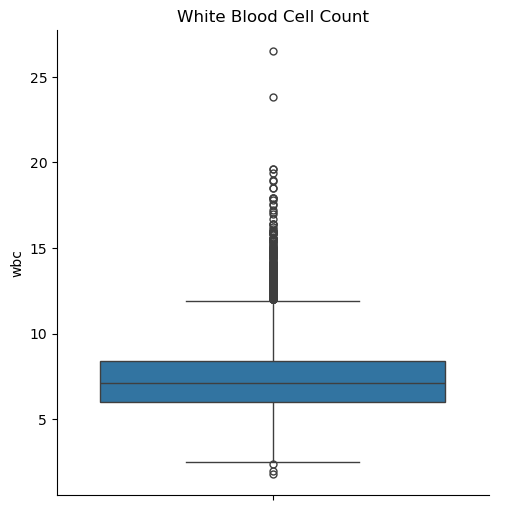

In [6]:
# For numerical columns, using IQR (Interquartile Range) method to identify outliers in white blood cell count
Q1 = drug_safety['wbc'].quantile(0.25)
Q3 = drug_safety['wbc'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers, wbc was chosen for its larger standard deviation
outliers = drug_safety[(drug_safety['wbc'] < lower_bound) | (drug_safety['wbc'] > upper_bound)]
print("\nOutliers in wbc:\n", outliers)

sns.catplot(kind='box', data=drug_safety, y='wbc') 
plt.title('White Blood Cell Count')
plt.show()

# outliers determined to be left in dataset

Verify cleaned

In [7]:
# Re-run descriptive statistics and info
print("\nCleaned DataFrame Info:\n", drug_safety.info())
print("\nCleaned Numerical Statistics:\n", drug_safety.describe())

# Check for remaining missing values or duplicates
print("\nMissing Values After Cleaning:\n", drug_safety.isna().sum())
print("\nNumber of Duplicate Rows After Cleaning:", drug_safety.duplicated().sum())

# Sample the cleaned data to visually inspect
print("\nSample of Cleaned Data:\n", drug_safety.sample(5))

# Distinctness check for categorical columns 
for col in drug_safety.select_dtypes(include=['object', 'category']).columns:
    print(f"\nValue Counts for {col}:\n", drug_safety[col].value_counts(dropna=False))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16103 entries, 0 to 16102
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   age              16103 non-null  int64   
 1   sex              16103 non-null  category
 2   trx              16103 non-null  category
 3   week             16103 non-null  int64   
 4   wbc              9128 non-null   float64 
 5   rbc              9127 non-null   float64 
 6   adverse_effects  16103 non-null  boolean 
 7   num_effects      16103 non-null  int64   
 8   wbc_missing      16103 non-null  int32   
 9   rbc_missing      16103 non-null  int32   
dtypes: boolean(1), category(2), float64(2), int32(2), int64(3)
memory usage: 818.1 KB

Cleaned DataFrame Info:
 None

Cleaned Numerical Statistics:
                 age         week          wbc          rbc   num_effects  \
count  16103.000000  16103.00000  9128.000000  9127.000000  16103.000000   
mean      64.117556      

Terminology
The z-statistic: Based on the sample, how many standard deviations your observed result is from what you'd expect if there was no difference\
The P-value: Based on the sample, is the probability of seeing the result as extreme if there truly were no effect or difference in the real world

---

Does the proportion of adverse effects differ significantly between the Drug and Placebo groups?

* Null: placebo adverse effects - drug adverse effects = 0
* Alternate: placebo adverse effects - drug adverse effects != 0

Comparing two proportions: 2 Sample Proportion Z-test

Assumptions
* Random Samples: Both samples drawn independently and randomly 
* Independence of Observations: outcomes for individual subjects within each sample are independent of each other. Selection of subjects for one group are also not affected by selections of subjects for the other group. 
* Categorical Data with two outcomes: "success/failure" or "True/False"
* Large enough sample sizes for normality: # successes >= 10 and # failures >= 10 for difference in sample proportions to approximate normal 

Conclusion\
Based on the sample data, there was not enough statistically significant evidence (Z= -0.045, p= 0.964) to suggest that the drug causes a different proportion of adverse events compared to the placebo. While the drug group showed a slightly higher rate of adverse events, this difference is so small that it's likely just random noise and not a real effect of the drug.

In [8]:

# gather counts for proportions
adverse_effects_by_trx = drug_safety.groupby('trx')['adverse_effects'].value_counts()
adverse_effects_by_trx = adverse_effects_by_trx.unstack(fill_value=0)
adverse_effects_by_trx['total_obs'] = adverse_effects_by_trx.sum(axis=1)

print(adverse_effects_by_trx)

# responses defined as adverse effect = True and formatted [placebo, drug]
responses = [512,1024]
observations = [5376,10727]

two_sample_z_statistic, two_sample_p_value = proportions_ztest(responses,observations,alternative='two-sided')
print(two_sample_z_statistic, two_sample_p_value)

adverse_effects  False  True  total_obs
trx                                    
Drug              9703  1024      10727
Placebo           4864   512       5376
-0.0452182684494942 0.9639333330262475


C:\Users\rcdan\AppData\Local\Temp\ipykernel_20720\55448343.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adverse_effects_by_trx = drug_safety.groupby('trx')['adverse_effects'].value_counts()


---
Is there a statistically significant difference in the number of adverse effects between the drug and placebo groups?

* Null: No difference in number of adverse effects between drug and placebo groups
* Alternative: There is a difference in number of adverse effects between drug and placebo groups

Categorical, Ordinal/Continuous Data: Mann-Whitney U Test/Wilcoxon Rank-Sum Test\
Used to compare two independent groups with an ordinal or continuous outcome. Treat "num_effects" as an ordinal score for each patient.
Compares the ranks of the observations from the two groups. It tests if one group tends to have higher (or lower) ranks than the other.

Assumptions for Mann-Whitney U Test/Wilcoxon Rank-Sum Test
* Independent, random samples: Selection of subjects for one group are also not affected by selections of subjects for the other group. 
* Ordinal or continuous data
* Note- non-parametric test (doesn't assume normality)

Conclusion\
Based upon the sample data, was not enough statistical evidence (p= 0.941) to suggest there is a difference in number of adverse effects between drug and placebo groups.

In [9]:
# Subset data for groups
drug_group = drug_safety[drug_safety['trx'] == 'Drug']['num_effects']
placebo_group = drug_safety[drug_safety['trx'] == 'Placebo']['num_effects']

mwu_results_trx = pingouin.mwu(x=drug_group, y=placebo_group, alternative='two-sided')
print(mwu_results_trx)

          U-val alternative     p-val       RBC      CLES
MWU  28844703.0   two-sided  0.940732  0.000365  0.500183


---
Is there is a statistically significant difference in the ages between the drug and placebo groups?\
Is age a confounding variable?

* Null: No difference in age between drug and placebo groups
* Alternative: There is a difference in age between drug and placebo 

Categorical, Ordinal/Continuous Data: Mann-Whitney U Test/Wilcoxon Rank-Sum Test

Conclusion\
Based upon the sample data, there was not enough statistical evidence (p= 0.257) to suggest there is a difference in ages between drug and placebo groups.

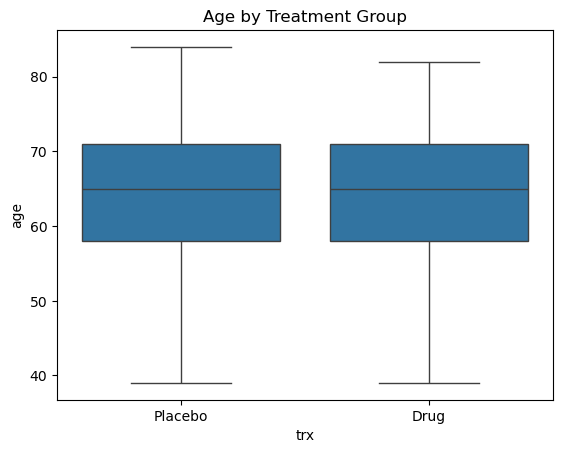

          U-val alternative     p-val      RBC      CLES
MWU  29149339.5   two-sided  0.256963  0.01093  0.505465


In [10]:

# subsetting data into groups
drug_group_ages = drug_safety[drug_safety['trx'] == 'Drug']['age']
placebo_group_ages = drug_safety[drug_safety['trx'] == 'Placebo']['age']

sns.boxplot(data=drug_safety, x='trx',y='age',order=['Placebo','Drug'])
plt.title('Age by Treatment Group')
plt.show()

# Mann-Whitney U Test/Wilcoxon Rank-Sum Test
mwu_results_ages = pingouin.mwu(x=drug_group_ages, y=placebo_group_ages, alternative='two-sided')
print(mwu_results_ages)
age_group_effects_p_value = mwu_results_ages['p-val'].iloc[0]

---
Is there a statistical significant difference in gender between drug and placebo groups? 
Is gender a confounding variable?

* Null: No difference in gender between drug group and placebo group
* Alternative: There is a difference in gender between drug group and placebo group

Categorical Data: Chi-Squared Test\
It tests for an association or independence between two categorical variables, rather than comparing means or medians of numerical data. The Chi-squared test compares observed frequencies with the expected frequencies.

Assumptions for Chi-Squared Test
* Random Samples: Observations are a random sample from population, patient's assigned independently 
* Independence of Observations: patient's outcomes should be independent of other patient's outcomes
* Expected Frequencies: each cell of frequency table is >= 5
* Note- non-parametric test (doesn't assume normality)

Conclusion\
Based upon the sample data, there was statistical  evidence (p= 0.003) to suggest there is a difference in gender between drug and placebo groups. Drug/Placebo for females: 2591/1183 = 2.2,  Drug/Placebo for males: 8135/4192 = 1.94.

Recommendation: equal drug/placebo ratio needed for each gender to eliminate presence of confounding variable. Run Chi-Squared to see if difference in adverse effects between genders

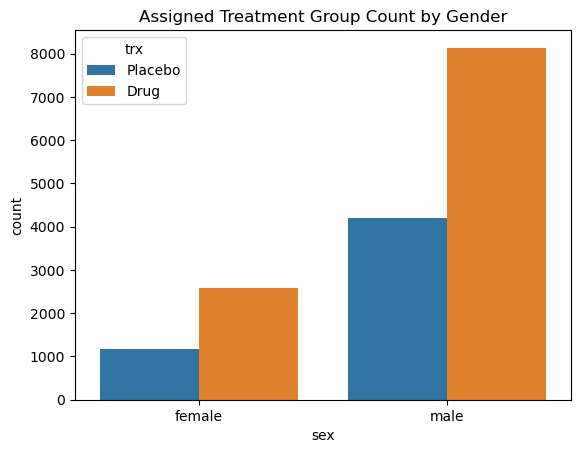

In [11]:
# Exploratory Analysis: Raw counts 
sns.countplot(data=drug_safety, x='sex',hue='trx',hue_order=['Placebo','Drug'])
plt.title('Assigned Treatment Group Count by Gender')
plt.show()

In [12]:
expected_gender, observed_gender, stats_gender = pingouin.chi2_independence(data=drug_safety, x='trx',y='sex')
print(expected_gender, observed_gender, stats_gender)

gender_p_value = stats_gender['pval'].iloc[0]
print(gender_p_value)

sex           female         male
trx                              
Drug     2514.713097  8212.286903
Placebo  1260.286903  4115.713097 sex      female    male
trx                    
Drug     2591.5  8135.5
Placebo  1183.5  4192.5                  test    lambda      chi2  dof      pval    cramer     power
0             pearson  1.000000  9.173764  1.0  0.002455  0.023868  0.857434
1        cressie-read  0.666667  9.196020  1.0  0.002425  0.023897  0.858259
2      log-likelihood  0.000000  9.241700  1.0  0.002366  0.023956  0.859941
3       freeman-tukey -0.500000  9.276997  1.0  0.002320  0.024002  0.861228
4  mod-log-likelihood -1.000000  9.313198  1.0  0.002275  0.024049  0.862537
5              neyman -2.000000  9.388373  1.0  0.002184  0.024146  0.865221
0.0024550912316262507


---
Is there a statistically significant difference in the presence of adverse effects between gender?

* Null: No difference in adverse effects between gender
* Alternative: There is a difference in adverse effects between gender

Categorical Data: Chi-Squared Test\
It tests for an association or independence between two categorical variables, rather than comparing means or medians of numerical data. The Chi-squared test compares observed frequencies with the expected frequencies.

Conclusion\
Based upon the sample data, There was statistical  evidence (Chi^2: 22.208, p < 0.001) to suggest there is a difference in adverse effects between genders. 

Recommendation: Run 2-sample proportions verify and to see magnitude of difference.

In [13]:
expected_gender_ae, observed_gender_ae, stats_gender_ae = pingouin.chi2_independence(data=drug_safety, x='sex',y='adverse_effects')
print(expected_gender_ae, observed_gender_ae, stats_gender_ae)

gender_ae_p_value = stats_gender_ae['pval'].iloc[0]
print(gender_ae_p_value)

adverse_effects         False        True 
sex                                       
female            3414.918028   360.081972
male             11152.081972  1175.918028 adverse_effects    False   True 
sex                             
female            3340.5   434.5
male             11226.5  1101.5                  test    lambda       chi2  dof      pval    cramer     power
0             pearson  1.000000  22.207812  1.0  0.000002  0.037136  0.997043
1        cressie-read  0.666667  21.914284  1.0  0.000003  0.036890  0.996749
2      log-likelihood  0.000000  21.359255  1.0  0.000004  0.036420  0.996112
3       freeman-tukey -0.500000  20.969533  1.0  0.000005  0.036086  0.995594
4  mod-log-likelihood -1.000000  20.601251  1.0  0.000006  0.035768  0.995044
5              neyman -2.000000  19.924661  1.0  0.000008  0.035176  0.993856
2.4467622964249306e-06


---
Is there a statistically significant difference in proportion of adverse effects between gender?
* Null: proportion of adverse effects in females - proportion of adverse effects in males = 0
* Alternative: proportion of adverse effects in females - proportion of adverse effects in males != 0

Comparing two proportions: 2 Sample Proportion Z-test

Conclusion\
Based on the sample data, there was statistical  evidence (Z = 4.74, p-value < 0.001) to conclude that there is a difference in the proportion of adverse effects between females and males. Specifically, females showed 2.59% higher rate of adverse events with 11.52% females experiencing adverse effects compared to 8.93% in males. Although there is a statistical difference, whether this is clinically significant would depend on the context of the drug and adverse effects. The test only shows association, or correlation, and not necessarily causation that being female will result in more adverse effects. More testing would be needed to confirm. Despite statistically more females both receiving the drug and reacting to it, the drug in previous tests still did not show to produce statistically more adverse effects. This leads to the conclusions that 1. based upon the sample data, the drug is safe with respect to adverse effects, but 2. To improve future test quality, the ratio of drug/placebo should be the same across gender. 

In [14]:
adverse_effects_by_gender = drug_safety.groupby('sex')['adverse_effects'].value_counts()
adverse_effects_by_gender = adverse_effects_by_gender.unstack(fill_value=0)
adverse_effects_by_gender['total_obs'] = adverse_effects_by_gender.sum(axis=1)

print(adverse_effects_by_gender)

# [female, male]
responses_gender = [435,1101]
observations_gender = [3775,12328]

two_sample_z_statistic_gender, two_sample_p_value_gender = proportions_ztest(responses_gender,observations_gender,alternative='two-sided')
print(two_sample_z_statistic_gender, two_sample_p_value_gender)

adverse_effects  False  True  total_obs
sex                                    
female            3340   435       3775
male             11227  1101      12328
4.744178992994354 2.0935367516181726e-06


C:\Users\rcdan\AppData\Local\Temp\ipykernel_20720\733511195.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adverse_effects_by_gender = drug_safety.groupby('sex')['adverse_effects'].value_counts()
